In [18]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.optimize as optimize
from scipy import stats

# TO DO
1. ogarnać dokładnie kod
2. obliczyć zmienność dla złota żeby mieć potem plot

In [8]:
df = pd.read_csv(r'C:\Users\maxim\Documents\GitHub\gold-forecast\data\data_returns_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])
df.dropna(inplace=True) # I didnt drop the first row after pct_change in data exploration and preparation part, thus dropna here
df.head()

,Gold
date,
1986-01-03,0.001379
1986-01-06,0.003826
1986-01-07,0.006098
1986-01-08,0.007879
1986-01-09,0.002706


In [ ]:
return_array = np.array(df['Gold'])

In [5]:
# GARCH model
def garch_forward(return_rate,variance,coefficients):
    ''' data type: float, float, 1d array(length=3)'''
    
    # Coefficients
    alpha,beta,omega = coefficients
    # Calculate
    return omega + alpha*return_rate*return_rate + beta*variance

In [9]:
initial_variance = df['Gold'][0]-df['Gold'].mean()

0.001139138054609441

In [23]:
# Function for optimization

def garch_for_optimization(array): 
    ''' data type: 1d array(length=3)'''
    
    # Coeffcients
    alpha,beta,omega = array 
    
    # Variables
    sum_probability = 0 # to maximize
    variance = initial_variance
    
    for i in range(1,return_array.shape[0]):  # exclude the first value because it's nan.
        return_rate = return_array[i]  
        
        # in case something goes wrong
        if variance<=0:
            print("Negative variance")
            break
        
        # calculate probability in a single day
        probability = -np.log(variance) - return_rate * return_rate / variance
        
        # add to the sum
        sum_probability += probability
        
        # calculate next day's variance by GARCH
        variance = garch_forward(return_rate,variance,array)
   
    return -sum_probability # note the sign(-); because scipy.optimize requires a function to be minimized

In [24]:
# Optimize
# if execute is set TRUE, optimization which takes some time will be initiated
execute = True    

if execute:
    bounds = optimize.Bounds([0,0,0],[1,1,np.inf])
    initial_guess = [0.14,0.76,2.97]  # V-Lab's estimate

    # Trust-constr performed the best 
    optimize_res_trust = optimize.minimize(garch_for_optimization,initial_guess,method='trust-constr',bounds=bounds)

Negative variance
Negative variance
Negative variance
Negative variance


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [25]:
print('optimization result:')
print('alpha =',optimize_res_trust.x[0])
print('beta =',optimize_res_trust.x[1])
print('omega =',optimize_res_trust.x[2])

optimization result:
alpha = 0.05417093435586603
beta = 0.9435152559424961
omega = 5.201357725771324e-07


In [26]:
# Estimate historical volatility with estimated coefficients

variance_array = np.zeros(df.shape[0],)  # Create array to store variance

# Values to be pre-assigned
variance_array[0] = np.nan  # Historical volatility cannot be estimated for the first one in full_data (06/03/2009)
variance_array[1] = initial_variance 

# Calculate historical volatilities using GARCH
for i in range(2,df.shape[0]):
    variance_array[i]=garch_forward(return_array[i-1],variance_array[i-1],optimize_res_trust.x)
    
# Adjust value to compare with VKOSPI (elaborated in 2-3-2)  
historical_volatility = np.sqrt(variance_array * 252) * 100

# Add to the dataset
df['Historical Volatility'] = historical_volatility
full_data = df.dropna()  # Drop NA (because of nan in historical volatility)

In [27]:
# Before visualizing, few matplotlib settings
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['axes.labelpad'] = 5.5  # space between axis and label
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titlepad'] = '20.0'

mpl.rcParams['legend.fontsize'] = 'x-large'

# mpl color settings
default_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

# and seaborn settings
sns.set_style('darkgrid')

In [29]:
full_data

,Gold,Historical Volatility
date,,
1986-01-06,0.003826,53.578241
1986-01-07,0.006098,52.074848
1986-01-08,0.007879,50.645842
1986-01-09,0.002706,49.294041
1986-01-10,0.020840,47.905745
...,...,...
2022-12-30,0.000000,14.812683
2023-01-03,0.016265,14.433734
2023-01-04,0.007622,15.296672


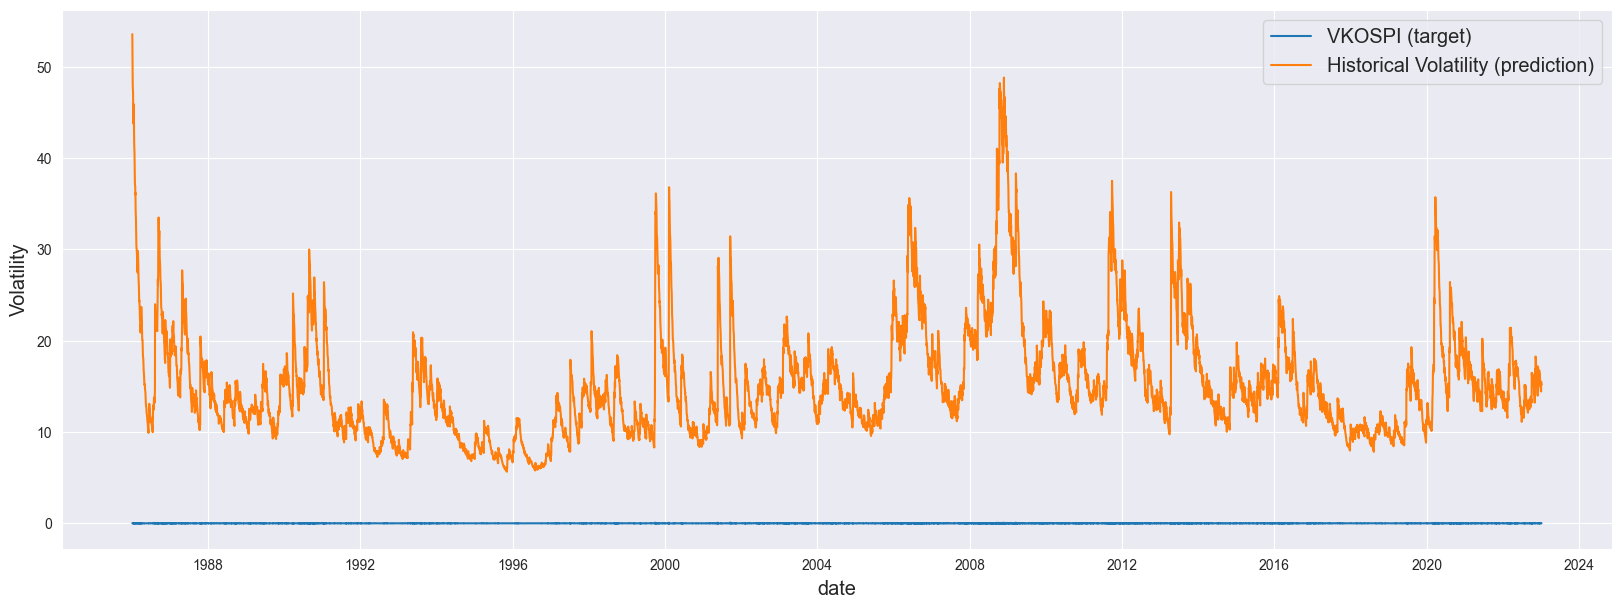

In [31]:
# Compare with VKOSPI (Visualization)
pd.plotting.register_matplotlib_converters()  # because of compatilbility issue with pd.Timestamp and matplotlib

fig, ax = plt.figure(figsize=(20,7)), plt.axes()
sns.lineplot(data=full_data,x=full_data.index ,y='Gold',label='VKOSPI (target)',ax=ax)
sns.lineplot(data=full_data,x=full_data.index,y='Historical Volatility',label='Historical Volatility (prediction)',ax=ax)
plt.ylabel('Volatility')
plt.show()

----


In [1]:
# basics
import pandas as pd
import numpy as np
import missingno as msno

# plots
import  matplotlib.pyplot as  plt
import matplotlib.patches as mpatches
import seaborn as sns

# statistics plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

# statistical tests and auto arima
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from pmdarima.arima import auto_arima
from arch import arch_model
from statsmodels.tsa.api import VAR

# metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv(r'C:\Users\maxim\Documents\GitHub\gold-forecast\data\data_returns_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])
df.dropna(inplace=True) 
dfp = pd.read_csv(r'C:\Users\maxim\Documents\GitHub\gold-forecast\data\data_nominal_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])


Text(0.5, 1.0, 'Gold returns per troy oz 1986-01-02 to 2023-01-06')

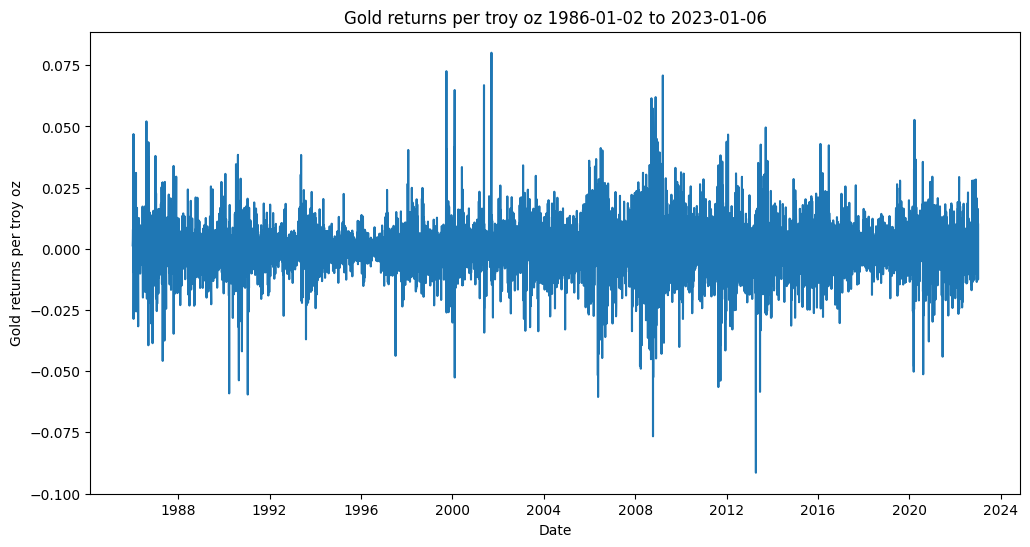

In [3]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=df.index, y='Gold', data=df, ax=ax)
ax.set_ylabel('Gold returns per troy oz')
ax.set_xlabel('Date')
ax.set_title('Gold returns per troy oz 1986-01-02 to 2023-01-06')

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


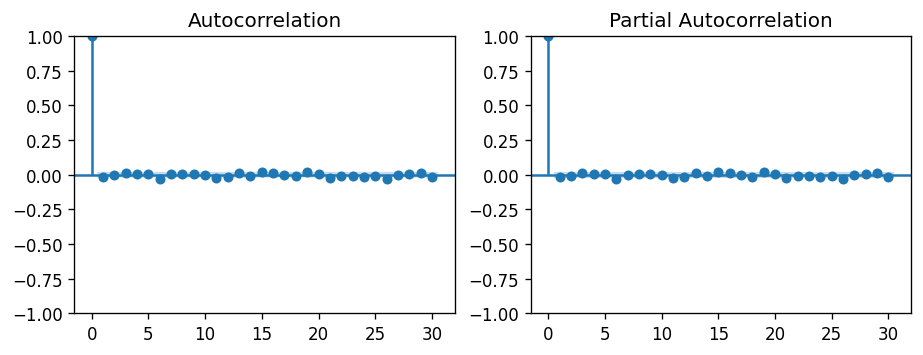

In [4]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
plot_acf(df['Gold'], ax=axes[0], lags=30)
plot_pacf(df['Gold'], ax=axes[1], lags=30)

plt.show()

In [5]:
def ts_plot(residuals, stan_residuals, lags=20):
    residuals.plot(title='GARCH Residuals', figsize=(10, 5))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=14)
    acf.set_figheight(5)
    acf.set_figwidth(10)
    pacf.set_figheight(5)
    pacf.set_figwidth(10)
    plt.show()

Calculating historical volatility

In [6]:
dfv = pd.DataFrame(df.Gold.rolling(20).var()).dropna()
dfv

,Gold
date,
1986-01-30,0.000239
1986-01-31,0.000271
1986-02-03,0.000280
1986-02-04,0.000318
1986-02-05,0.000317
...,...
2022-12-30,0.000103
2023-01-03,0.000076
2023-01-04,0.000071


In [7]:
dft = pd.DataFrame()
dft['log_ret'] = np.log(dfp['Gold']/dfp['Gold'].shift())
dft.index = dfp.index
dft.dropna(inplace=True)
volatility = pd.DataFrame(dft['log_ret'].rolling(20).std()**.5)
volatility.rename(columns={'log_ret':'hv'}, inplace=True)
volatility

,hv
date,
1986-01-03,NaN
1986-01-06,NaN
1986-01-07,NaN
1986-01-08,NaN
1986-01-09,NaN
...,...
2022-12-30,0.100352
2023-01-03,0.093312
2023-01-04,0.091602


Estimate full period volatility with GARCH(1,1)

In [8]:
model = arch_model(df,dist="Normal", vol = 'GARCH', p=1, q=1)
#Fit the model
model_fit_full = model.fit(disp='off')

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


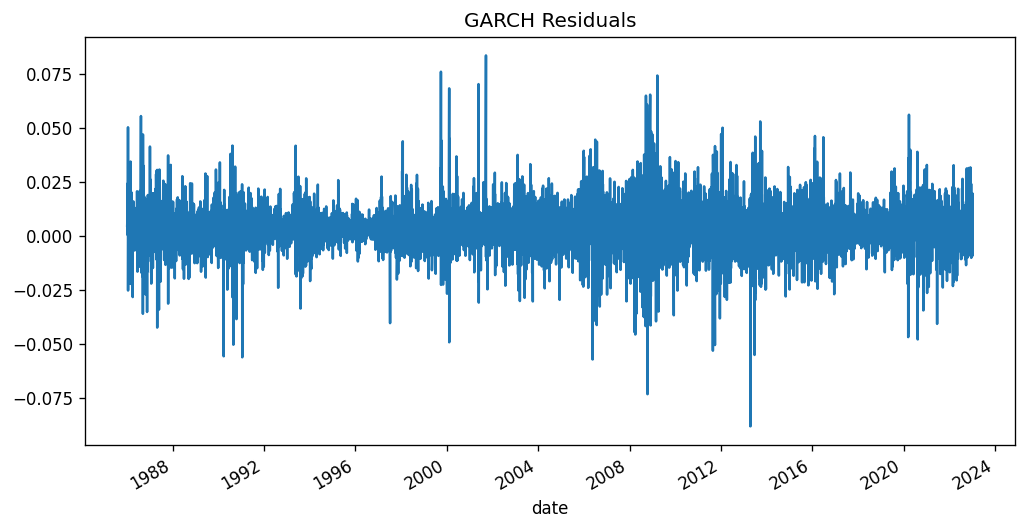

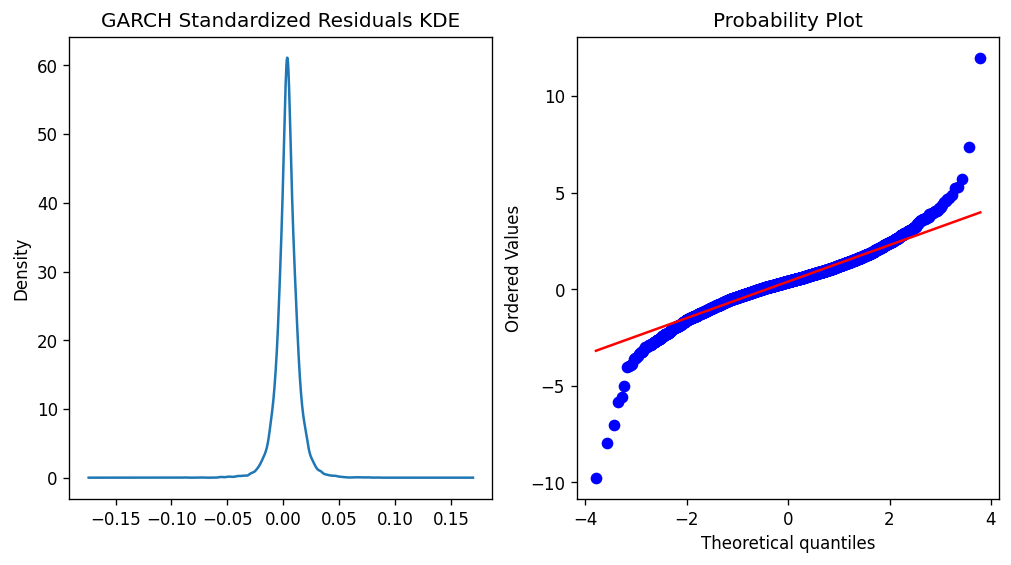

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


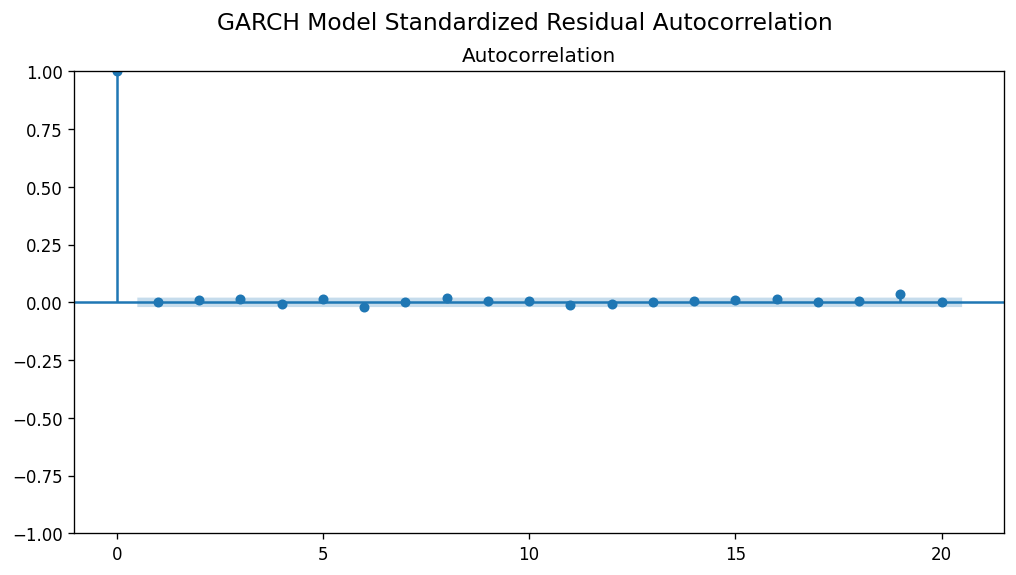

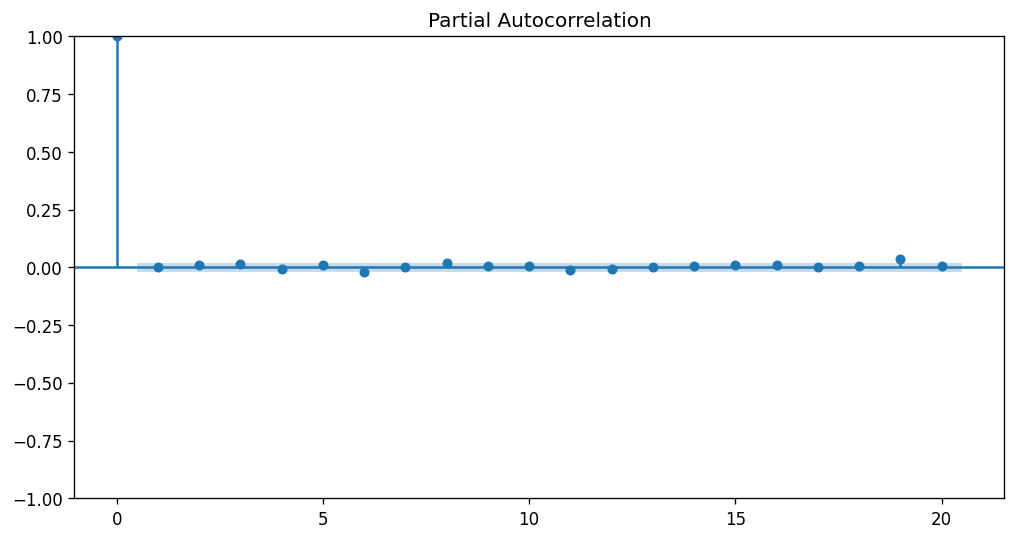

In [9]:
resid_full = model_fit_full.resid
st_resid_full = np.divide(resid_full, model_fit_full.conditional_volatility)
ts_plot(resid_full, st_resid_full)

In [10]:
garch_full = pd.DataFrame(model_fit_full._volatility)
garch_full.index = df.index

In [11]:
volatility.isna().sum()

hv    19
dtype: int64

Text(0.5, 1.0, 'Historical Volatility and GARCH estimation')

findfont: Font family 'stix' not found.
findfont: Font family 'stix' not found.
findfont: Font family 'stix' not found.
findfont: Font family 'stix' not found.
findfont: Font family 'stix' not found.
findfont: Font family 'stix' not found.


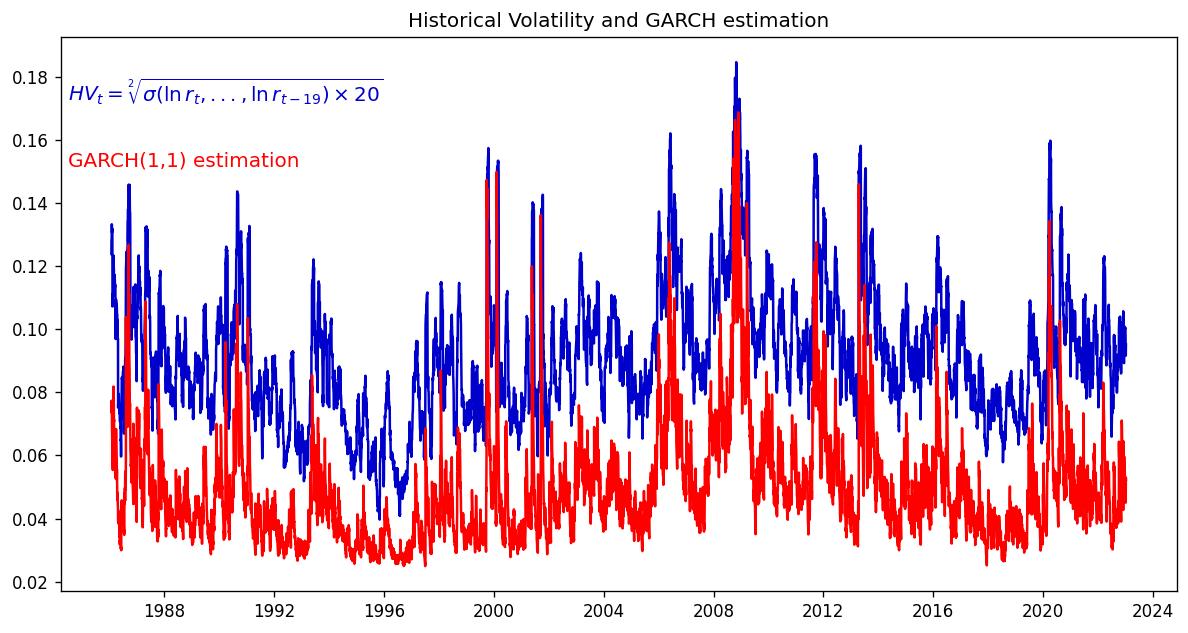

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

font1 = {'family': 'stix',
        'color':  'mediumblue',
        'weight': 'normal',
        'size': 12,
        }
font2 = {'family': 'stix',
        'color':  'red',
        'weight': 'normal',
        'size': 12,
        }

ax.plot(volatility.iloc[19:], color='mediumblue')
ax.plot(garch_full.iloc[19:]*5, color='red')
fig.text(x=0.13, y=0.79, s=r'$HV_t = \sqrt[2]{\sigma (\ln{r_t}, ... , \ln{r_{t-19}})\times20}$', fontdict=font1)
fig.text(x=0.13, y=0.7, s=r'GARCH(1,1) estimation', fontdict=font2)
ax.set_title('Historical Volatility and GARCH estimation')

In [50]:
np.sqrt(20)

4.47213595499958

Estimating GARCH and EGARCH on train

In [16]:
# data split
y_train_v, y_test_v = df[df.index<'2022-12-01'], df[(df.index.year==2022) & (df.index.month==12)]

# historical vol split
hv_train, hv_test = volatility[volatility.index<'2022-12-01'], volatility[(volatility.index.year==2022) & (volatility.index.month==12)]

GARCH

In [17]:
#Define a GARCH model
model_garch = arch_model(y_train_v,dist="Normal", vol = 'GARCH', p=1, q=1)
#Fit the model
model_fit_garch = model_garch.fit(disp='off')
#Summary of the model
model_fit_garch.summary()

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001002. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                30020.9
Distribution:                  Normal   AIC:                          -60033.9
Method:            Maximum Likelihood   BIC:                          -60005.4
                                        No. Observations:                 9124
Date:                Fri, Apr 21 2023   Df Residuals:                     9123
Time:                        13:17:35   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.5015e-05  9.015e-05      0.832      0.405 [-1.017e-04,2.517e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0042e-06  2.453e-12  8.170e+05      0.000 [2.004e-06,2.004e-06]
alpha[1]       0.1000  4.394e-03     22.757 1.229e-114   [9.139e-02,  0.109]
beta[1]        0.8800  7.664e-04   1148.238      0.000     [  0.878,  0.882]
============================================================================

Covariance estimator: robust
"""

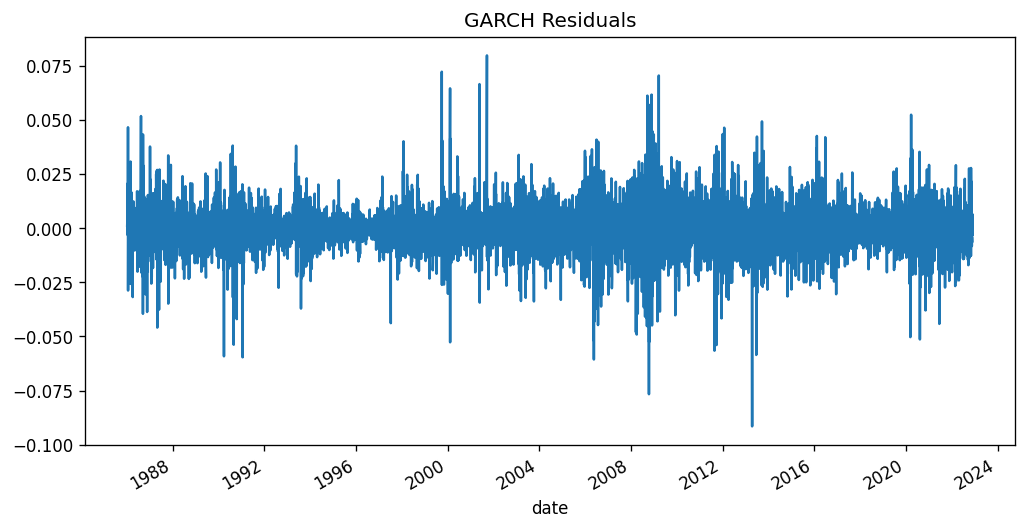

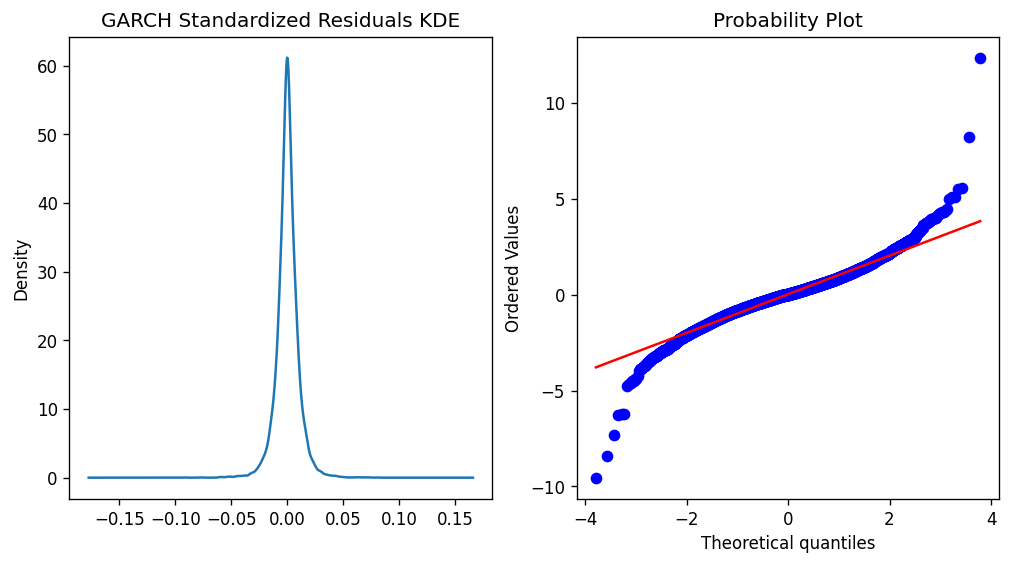

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


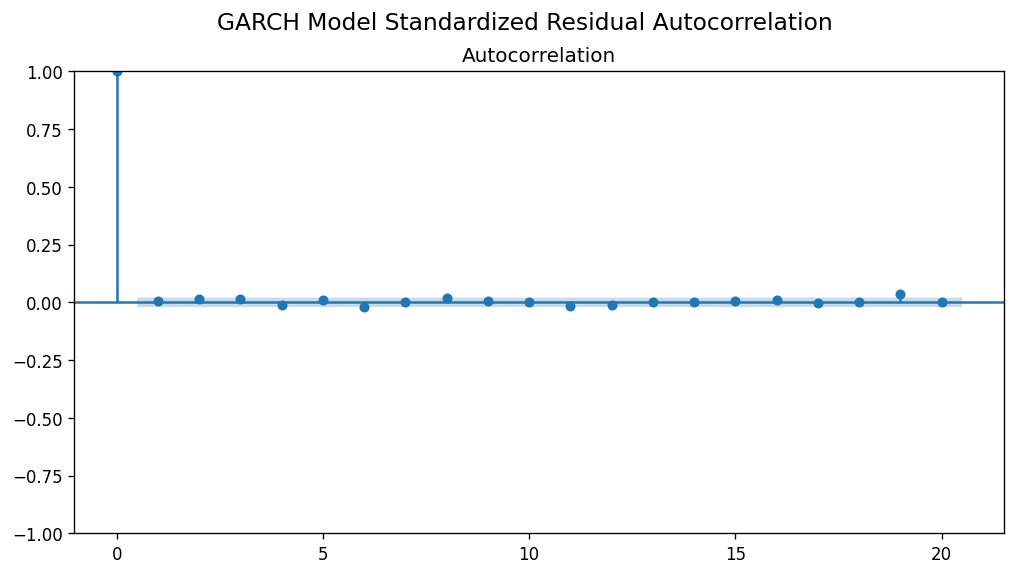

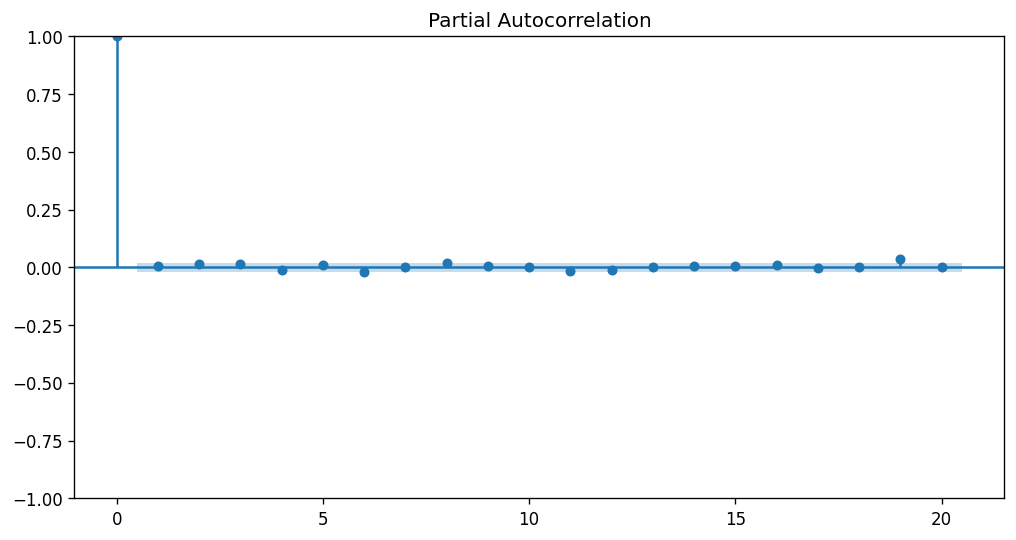

In [18]:
resid_garch = model_fit_garch.resid
st_resid_garch = np.divide(resid_garch, model_fit_garch.conditional_volatility)
ts_plot(resid_garch, st_resid_garch)

In [31]:
forecasts_garch = model_fit_garch.forecast(horizon=y_test_v.shape[0], reindex=False)

In [33]:
y_hat_garch = forecasts_garch.variance.values
y_hat_garch = pd.DataFrame(y_hat_garch.reshape(20))
y_hat_garch.index = y_test_v.index
y_hat_garch

,0
date,
2022-12-01,0.000056
2022-12-02,0.000057
2022-12-05,0.000058
2022-12-06,0.000059
2022-12-07,0.000060
2022-12-08,0.000061
2022-12-09,0.000061
2022-12-12,0.000062
2022-12-13,0.000063


In [34]:
garch_full[(garch_full.index.year==2022) & (garch_full.index.month==12)]

,0
date,
2022-12-01,0.008547
2022-12-02,0.012903
2022-12-05,0.012378
2022-12-06,0.011703
2022-12-07,0.011082
2022-12-08,0.010798
2022-12-09,0.010521
2022-12-12,0.010193
2022-12-13,0.009686


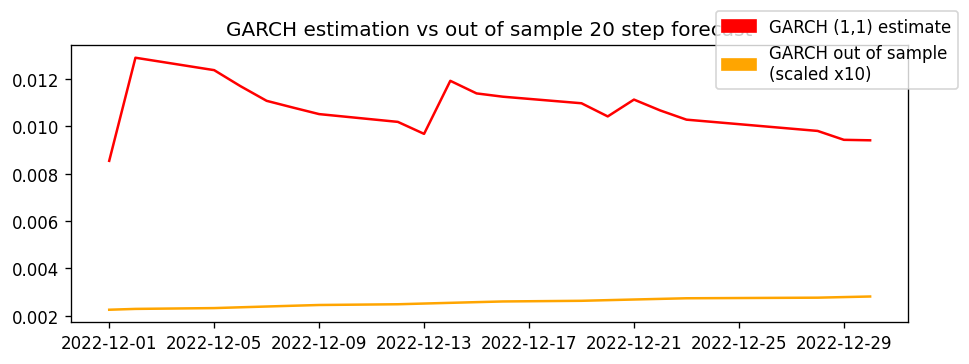

In [35]:
plt.plot(garch_full[(garch_full.index.year==2022) & (garch_full.index.month==12)], color='red')
plt.plot(y_hat_garch*40, color='orange')
plt.title('GARCH estimation vs out of sample 20 step forecast')
red_patch = mpatches.Patch(color='red', label='GARCH (1,1) estimate')
orange_patch = mpatches.Patch(color='orange', label='GARCH out of sample\n(scaled x10)')
plt.legend(handles=[red_patch, orange_patch], bbox_to_anchor=(0.76,0.81))

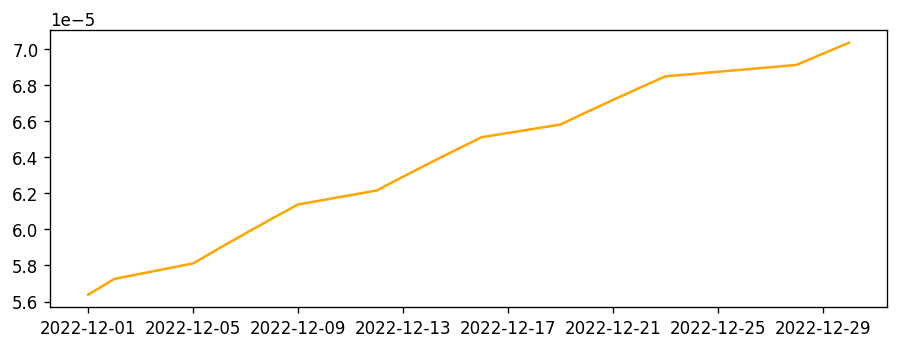

In [36]:
plt.plot(y_hat_garch, color='orange')

---
Experiments - scaling results

In [46]:
# calculating historical volatility
dft = pd.DataFrame()
dft['log_ret'] = np.log(dfp['Gold']/dfp['Gold'].shift())
dft.index = dfp.index
dft.dropna(inplace=True)
volatility = pd.DataFrame(dft['log_ret'].rolling(20).std()*20**.5)

In [47]:
# putting garch train volatility output into df
garch_v = pd.DataFrame(model_fit_garch._volatility)
garch_v.index = y_train_v.index

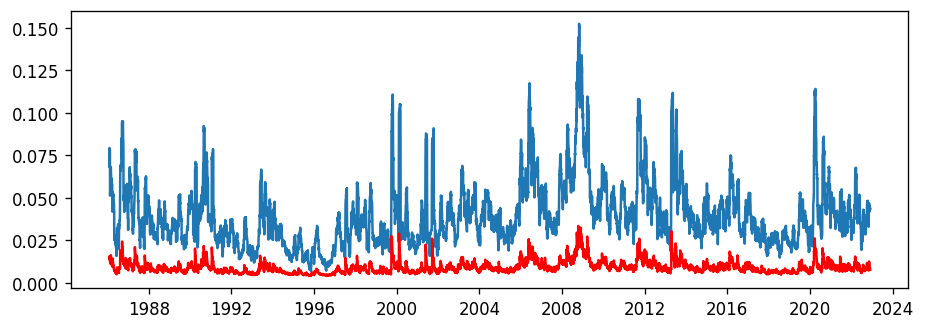

In [48]:
plt.plot(volatility[volatility.index<'2022-12-01'].iloc[19:])
plt.plot(garch_v.iloc[19:], color='red')

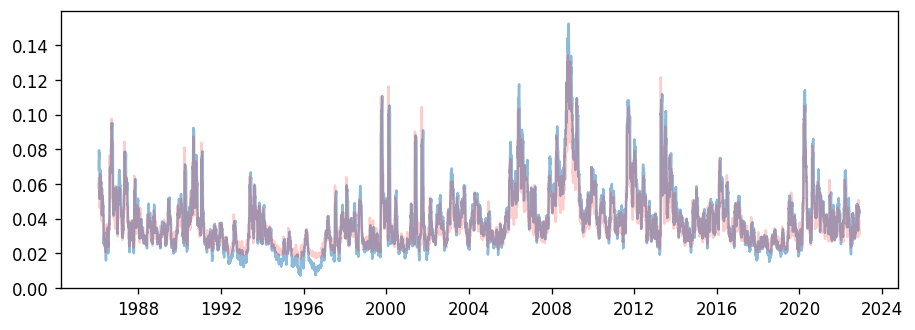

In [49]:
plt.plot(volatility[volatility.index<'2022-12-01'].iloc[19:], alpha=0.5)
plt.plot(garch_v.iloc[19:]*4, color='red', alpha=0.2)